## Задание

																		
1	Имеется две базы данных: база с ценами конкурентов (Data_Parsing) и внутрення база компании (Data_Company), для упрощения размещаем маленькие вымышленные выборки в листах данной книги																			
2	В базе парсинга есть два id определяющие однозначно товар: producer_id и producer_color																			
3	В базе компании есть аналогично два поля: item_id и color_id																			
4	Нам известно, что коды в двух базах отличаются наличием набора служебных символов. Для упрощения, в базе парсинга встречаются следующие символы: _, -, ~, \, /, 																			
5	Необходимо:																			
	a	Считать данные из excel в dataframe (Data_Parsing) и (Data_Company)																		
	b	Подтянуть к базе парсинга данные из базы компании: item_id, color_id, current_price и сформировать столбец разницы цен в % (цена конкурента к нашей цене)																		
	c	Определить сильные отклонения от среднего в разности цен в пределах бренда-категории (то есть убрать случайные выбросы сильно искажающие сравнение, критерий по вкусу, написать комментарий в коде почему такой: кратко в пару предложений) 																		
	d	Записать новый файл excel с базой парсинга, приклееными к ней столбцами из пункта "b" и учетом пункта "с" (можно добавить столбец outlier и проставить Yes для выбросов)																		

## Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Считываем данные

Считать данные из excel в dataframe (Data_Parsing) и (Data_Company)

In [38]:
data_parsing = pd.read_excel('2020-09-07 Python (на дом).xlsx', sheet_name='Data_Parsing') 
data_parsing.head()

brand Category   producer_id producer_color  price
0  Valentino    Shoes  aaaaa1111_11          black    167
1  Valentino    Shoes  aaaaa1111_12          black    188
2  Valentino    Shoes  aaaaa1111_13          black    184
3  Valentino    Shoes  aaaaa1111_14        bla//ck    196
4  Valentino    Shoes  aaaaa1111_15        bla\\ck    250

In [11]:
data_company = pd.read_excel('2020-09-07 Python (на дом).xlsx', sheet_name='Data_Company') 
data_company.head()

brand Category      item_id color_id  current price
0  Valentino    Shoes  aaaaa111111    black            247
1  Valentino    Shoes  aaaaa111112    black            161
2  Valentino    Shoes  aaaaa111113    black            234
3  Valentino    Shoes  aaaaa111114    black            167
4  Valentino    Shoes  aaaaa111115    black            153

## Очистка данных из парсинга

In [42]:
spec_chars = ["!",'"',"#","%","&","'","(",")",
              "*","+",",","-",".","/",":",";","<",
              "=",">","?","@","[","\\","]","^","_",
              "`","{","|","}","~","–"]
for char in spec_chars:
    data_parsing['producer_color'] = data_parsing['producer_color'].str.replace(char, "")
    data_parsing['producer_id'] = data_parsing['producer_id'].str.replace(char, "")

In [43]:
data_parsing.head()

brand Category  producer_id producer_color  price
0  Valentino    Shoes  aaaaa111111          black    167
1  Valentino    Shoes  aaaaa111112          black    188
2  Valentino    Shoes  aaaaa111113          black    184
3  Valentino    Shoes  aaaaa111114          black    196
4  Valentino    Shoes  aaaaa111115          black    250

## Посмотрим бегло на данные

In [77]:
data_parsing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   brand     75 non-null     object
 1   Category  75 non-null     object
 2   item_id   75 non-null     object
 3   color_id  75 non-null     object
 4   price     75 non-null     int64 
dtypes: int64(1), object(4)
memory usage: 3.1+ KB


In [78]:
data_company.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   brand          75 non-null     object
 1   Category       75 non-null     object
 2   item_id        75 non-null     object
 3   color_id       75 non-null     object
 4   current price  75 non-null     int64 
dtypes: int64(1), object(4)
memory usage: 3.1+ KB


In [79]:
data_parsing.describe()

price
count   75.00000
mean   219.80000
std     44.00952
min    153.00000
25%    181.00000
50%    211.00000
75%    258.00000
max    298.00000

In [80]:
data_company.describe()

current price
count      75.000000
mean      222.400000
std        43.091041
min       153.000000
25%       188.500000
50%       227.000000
75%       253.500000
max       299.000000

In [83]:
data_parsing.nunique()

brand        3
Category     2
item_id     75
color_id     3
price       63
dtype: int64

In [82]:
data_company.nunique()

brand             3
Category          2
item_id          75
color_id          3
current price    57
dtype: int64

In [84]:
sns.heatmap(data_parsing.isnull(), cmap='viridis')

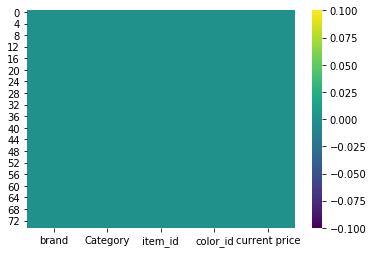

In [85]:
sns.heatmap(data_company.isnull(), cmap='viridis')

## Объединяем датасеты

Подтянуть к базе парсинга данные из базы компании: item_id, color_id, current_price и сформировать столбец разницы цен в % (цена конкурента к нашей цене)

In [47]:
#сгруппируем данные компании по item_id, color_id
data_company_sum = data_company.groupby(["item_id", "color_id"])["current price"].sum().reset_index()

In [56]:
#посмотрим, что получилось
data_company_sum

item_id color_id  current price
0   aaaaa111111    black            247
1   aaaaa111112    black            161
2   aaaaa111113    black            234
3   aaaaa111114    black            167
4   aaaaa111115    black            153
..          ...      ...            ...
70  sssss111131      red            165
71  sssss111132      red            196
72  sssss111133      red            236
73  sssss111134      red            222
74  sssss111135      red            275

[75 rows x 3 columns]

In [52]:
#переименуем колонки в датасете с парсингом, чтобы можно было смерджить с данными компании
data_parsing.columns = ['brand', 'Category', 'item_id', 'color_id', 'price']

In [200]:
#объединяем 2 датасета по 2м колонкам "item_id" и "color_id"
df = pd.merge(data_parsing, data_company_sum, on=["item_id", "color_id"], how="left")

In [201]:
#проверяем
df.head()

brand Category      item_id color_id  price  current price
0  Valentino    Shoes  aaaaa111111    black    167            247
1  Valentino    Shoes  aaaaa111112    black    188            161
2  Valentino    Shoes  aaaaa111113    black    184            234
3  Valentino    Shoes  aaaaa111114    black    196            167
4  Valentino    Shoes  aaaaa111115    black    250            153

In [202]:
#создаем новую колонку с разницей цен
#df['Diff'] = (((df['price'] - df['current price'])/df['price'])*100).round(2)
df['Diff'] = ((df['price']/df['current price'] - 1)*100).round(2)

In [203]:
df.head()

brand Category      item_id color_id  price  current price   Diff
0  Valentino    Shoes  aaaaa111111    black    167            247 -32.39
1  Valentino    Shoes  aaaaa111112    black    188            161  16.77
2  Valentino    Shoes  aaaaa111113    black    184            234 -21.37
3  Valentino    Shoes  aaaaa111114    black    196            167  17.37
4  Valentino    Shoes  aaaaa111115    black    250            153  63.40

In [204]:
#умножаем отр числа на -1
df['Diff'] = df['Diff'].map(lambda x: x*(-1) if x<0 else x)

In [205]:
df.head()

brand Category      item_id color_id  price  current price   Diff
0  Valentino    Shoes  aaaaa111111    black    167            247  32.39
1  Valentino    Shoes  aaaaa111112    black    188            161  16.77
2  Valentino    Shoes  aaaaa111113    black    184            234  21.37
3  Valentino    Shoes  aaaaa111114    black    196            167  17.37
4  Valentino    Shoes  aaaaa111115    black    250            153  63.40

## Определяем выбросы

Определить сильные отклонения от среднего в разности цен в пределах бренда-категории (то есть убрать случайные выбросы сильно искажающие сравнение, критерий по вкусу, написать комментарий в коде почему такой: кратко в пару предложений)

In [207]:
#сгруппируем данные по бренду и категории
df1 = df.groupby(["brand", "Category"])["Diff"].mean().reset_index()
df1.head(10)

brand Category       Diff
0        Brioni     Bags  23.577273
1        Brioni    Shoes  20.803571
2  Stone Island     Bags  19.635455
3  Stone Island    Shoes  23.033571
4     Valentino     Bags  23.130909
5     Valentino    Shoes  29.087143

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe8f9669250>]],
      dtype=object)

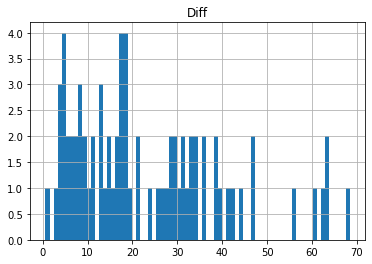

In [208]:
#посмотрим на распределение разницы в ценах на всех данных сразу
df.hist(column = 'Diff', bins = len(df.Diff.value_counts()))

а теперь по очереди посмотрим на распределение разницы по 6 группировкам бренд-категория

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe9005f9610>]],
      dtype=object)

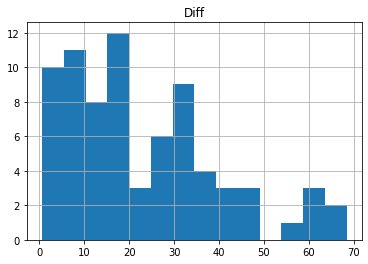

In [218]:
df.hist(column = 'Diff', bins = len(df[(df.brand == 'Valentino') & (df.Category == 'Shoes')].Diff.value_counts()))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe9006f0b90>]],
      dtype=object)

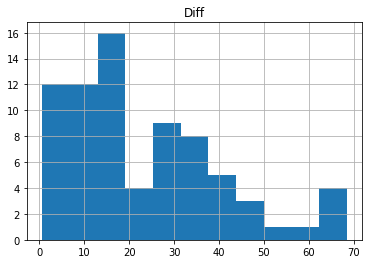

In [219]:
df.hist(column = 'Diff', bins = len(df[(df.brand == 'Valentino') & (df.Category == 'Bags')].Diff.value_counts()))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe9007e2210>]],
      dtype=object)

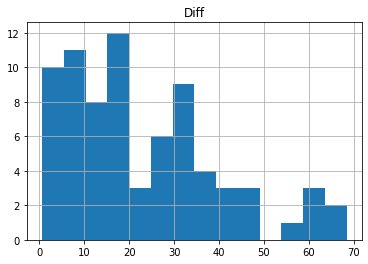

In [220]:
df.hist(column = 'Diff', bins = len(df[(df.brand == 'Brioni') & (df.Category == 'Shoes')].Diff.value_counts()))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe90056d990>]],
      dtype=object)

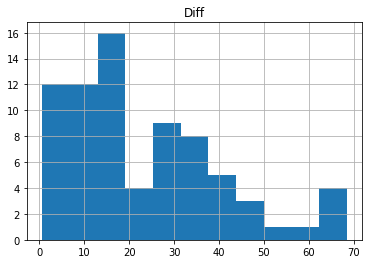

In [221]:
df.hist(column = 'Diff', bins = len(df[(df.brand == 'Brioni') & (df.Category == 'Bags')].Diff.value_counts()))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe90045b550>]],
      dtype=object)

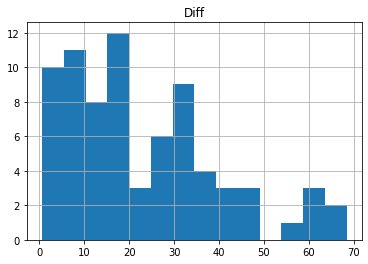

In [222]:
df.hist(column = 'Diff', bins = len(df[(df.brand == 'Stone Island') & (df.Category == 'Shoes')].Diff.value_counts()))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe8ff67dad0>]],
      dtype=object)

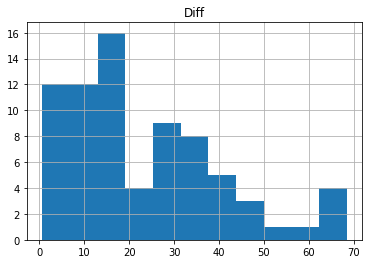

In [223]:
df.hist(column = 'Diff', bins = len(df[(df.brand == 'Stone Island') & (df.Category == 'Bags')].Diff.value_counts()))

Судя по графикам, выбросы присутствуют

Попробуем отфильтровать выбросы и воспользуемся формулой интерквартильного расстояния. Выбросом считаются такие значения, которые лежат вне рамок [Q1 -1.5IQR : Q3+1.5IQR], где IQR = percentile(75) - percentile(25).

Для начала, посмотрим на boxplot для разницы в цене на всех данных безу группировки. Данный вид графика делит данные на 4 части. Та часть данных, которая отделена слева и справа двумя вертикальными линиями (находится внутри коробки) содержит 50% данных, так как левая линия обозначает первый квартиль (25-й перцентиль), а правая линия обозначает третий квартиль (75-й перцентиль). Большой вертикальной линией выделена медиана:

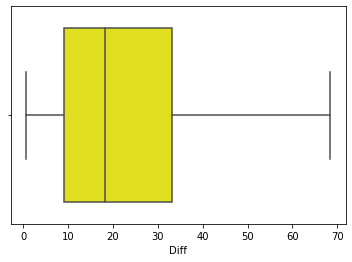

In [209]:
sns.boxplot(df.Diff, color='yellow');

выбросов нет

а теперь посмотрим на boxplot`ы для разницы в цене на сгруппированных данных

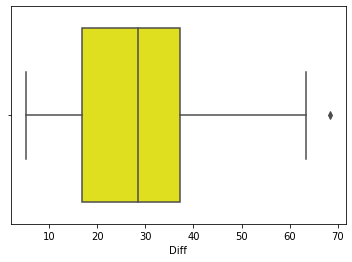

In [224]:
sns.boxplot(df[(df.brand == 'Valentino') & (df.Category == 'Shoes')].Diff, color='yellow');

уже на первом графике видно, что есть по крайней мере 1 выброс

Метод межквартильного расстояния выделяет как выбросы все значения, находящиеся за пределами коробки. Посмотрим, сколько выбросов он найдет:

In [153]:
def outliers_iqr(ys):
    #находим квартили
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    #находим межквартильное расстояние
    iqr = quartile_3 - quartile_1
    #нижняя граница коробки
    lower_bound = quartile_1 - (iqr * 1.5)
    #верхняя граница коробки
    upper_bound = quartile_3 + (iqr * 1.5)
    #возращаем только те значения и их индексы, ктр больше upper_bound и меньше lower_bound
    return ys[((ys > upper_bound) | (ys < lower_bound))]

In [240]:
out1 = outliers_iqr(df[(df.brand == 'Valentino') & (df.Category == 'Shoes')].Diff)

In [241]:
out1

12    68.42
Name: Diff, dtype: float64

проделаем то же самое для остальных 5ти группировок

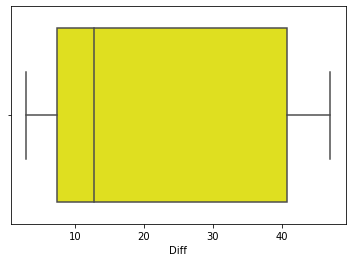

In [243]:
sns.boxplot(df[(df.brand == 'Valentino') & (df.Category == 'Bags')].Diff, color='yellow');

In [231]:
sns.boxplot(df[(df.brand == 'Brioni') & (df.Category == 'Bags')].Diff, color='yellow');

In [242]:
out2 = outliers_iqr(df[(df.brand == 'Brioni') & (df.Category == 'Bags')].Diff)
out2

45    63.69
Name: Diff, dtype: float64

In [244]:
sns.boxplot(df[(df.brand == 'Brioni') & (df.Category == 'Shoes')].Diff, color='yellow');

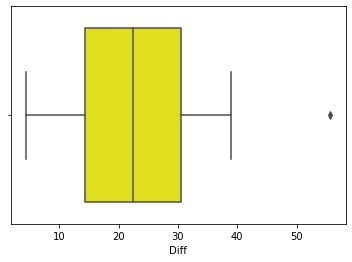

In [245]:
sns.boxplot(df[(df.brand == 'Stone Island') & (df.Category == 'Shoes')].Diff, color='yellow');

In [246]:
out3 = outliers_iqr(df[(df.brand == 'Stone Island') & (df.Category == 'Shoes')].Diff)
out3

55    55.68
Name: Diff, dtype: float64

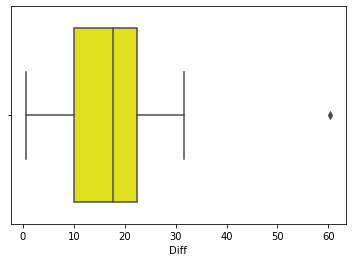

In [247]:
sns.boxplot(df[(df.brand == 'Stone Island') & (df.Category == 'Bags')].Diff, color='yellow');

In [248]:
out4 = outliers_iqr(df[(df.brand == 'Stone Island') & (df.Category == 'Bags')].Diff)
out4

65    60.38
Name: Diff, dtype: float64

In [255]:
#соберем все выбросы в датафрейм
out = pd.DataFrame(pd.concat([out1, out2, out3, out4], axis=0))
out

Diff
12  68.42
45  63.69
55  55.68
65  60.38

In [259]:
#добавим новую колонку 
out['outlier'] = True

попробуем другой метод - z-статистику

In [275]:
def z_score_method(df, variable_name):
    columns = df.columns
    z = np.abs(stats.zscore(df))
    threshold = 3
    outlier = []
    index=0
    for item in range(len(columns)):
        if columns[item] == variable_name:
            index = item
    for i, v in enumerate(z[:, index]):
        if v > threshold:
            outlier.append(i)
        else:
            continue
    return outlier

out_z = z_score_method(pd.DataFrame(df[(df.brand == 'Stone Island') & (df.Category == 'Bags')].Diff), 'Diff')
print(out_z)

[]


С помощью этого метода выбросы не обнаружены (проверила для всех 6ти группировок бренд-категория)

## Сохраняем данные в файл

Записать новый файл excel с базой парсинга, приклееными к ней столбцами из пункта "b" и учетом пункта "с" (можно добавить столбец outlier и проставить Yes для выбросов)

In [284]:
#объединяем 2 датафрейма
df_final = df.merge(out,left_on=['Diff'],right_on=['Diff'],how='left')
df_final

brand Category      item_id color_id  price  current price   Diff  \
0      Valentino    Shoes  aaaaa111111    black    167            247  32.39   
1      Valentino    Shoes  aaaaa111112    black    188            161  16.77   
2      Valentino    Shoes  aaaaa111113    black    184            234  21.37   
3      Valentino    Shoes  aaaaa111114    black    196            167  17.37   
4      Valentino    Shoes  aaaaa111115    black    250            153  63.40   
..           ...      ...          ...      ...    ...            ...    ...   
70  Stone Island     Bags  sssss111131      red    164            165   0.61   
71  Stone Island     Bags  sssss111132      red    158            196  19.39   
72  Stone Island     Bags  sssss111133      red    194            236  17.80   
73  Stone Island     Bags  sssss111134      red    256            222  15.32   
74  Stone Island     Bags  sssss111135      red    205            275  25.45   

   outlier  
0      NaN  
1      NaN  
2      NaN  
3      NaN  
4      NaN  
..     ...  
70     NaN  
71     NaN  
72     NaN  
73     NaN  
74     NaN  

[75 rows x 8 columns]

In [287]:
#заменим NaN на False
df_final['outlier'].fillna(False,inplace=True)

In [290]:
df_final.outlier.unique()

array([False,  True])

In [289]:
df_final.to_excel("Data.xlsx",
             sheet_name='Data_final')  